In [1]:
from google.colab import drive

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import json
import cv2

from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Any, Optional
import numpy as np
import torchvision.transforms as transforms
from torchvision import models


from PIL import Image

from IPython.display import display
from IPython import get_ipython

from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Any, Optional
import numpy as np
import torchvision.transforms as transforms

from PIL import Image

from IPython.display import display
from IPython import get_ipython

In [3]:
!pip install torchinfo

In [4]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import torchvision.transforms as transforms

In [5]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
json_path = '/content/drive/MyDrive/pt_data/real_road_data/pt_cr_list.json'
with open(json_path, 'r') as f:
    pt_cr_list = json.load(f)

In [7]:
file_path = '/content/drive/MyDrive/pt_data/real_road_data/notnormal'

X = []
y = []
for filename in os.listdir(file_path):
    if filename.endswith('.png'):
        img = cv2.imread(os.path.join(file_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)

        mp4_index = filename.find('.mp4')
        frame_index = filename.find('.png')
        if mp4_index != -1 and frame_index != -1:
            frame = filename[frame_index-2 :frame_index]
            if frame[0] == '_':
              frame = int(frame[1:])
            else:
              frame = int(frame)
            #frame = int(filename[frame_index-2 :frame_index])
            filename = filename[:mp4_index]
            for pt_cr in pt_cr_list:
                if pt_cr['video'] == filename and pt_cr['time'] == frame:
                    if pt_cr['label'] == 'pothole' or pt_cr['label'] == 'crack':
                        y.append(1)
                    else:
                        y.append(0)
                    break

In [8]:
print(len(X))
print(len(y))

24
24


In [9]:
filename

'OWD_20250527_121723_F'

In [10]:
print(frame)

22


In [11]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
load_path = "/content/drive/MyDrive/pt_data/ASL_0_6.pth"
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

In [14]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]    # numpy array, PIL.Image, Tensor 등 상관 없음
        label = self.y[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

In [20]:
test_data = MyDataset(X, y, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False,
                         num_workers=4, pin_memory=True, persistent_workers=True)

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([[14.0764]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


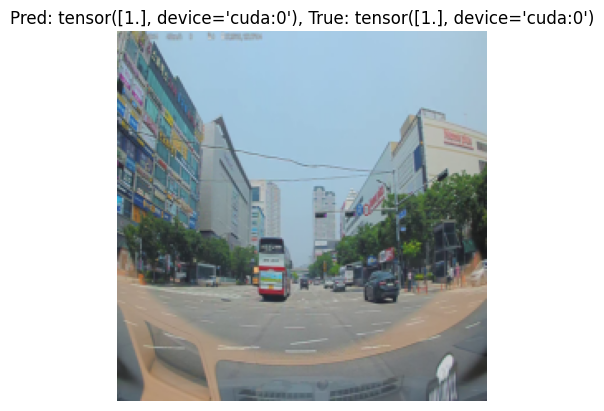

  4%|▍         | 1/24 [00:00<00:04,  5.57it/s]

tensor([[8.6213]], device='cuda:0')
tensor([[0.9998]], device='cuda:0')


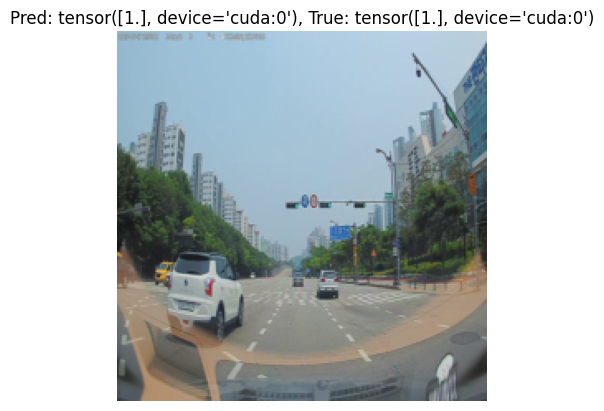

  8%|▊         | 2/24 [00:00<00:03,  6.36it/s]

tensor([[29.2383]], device='cuda:0')
tensor([[1.]], device='cuda:0')


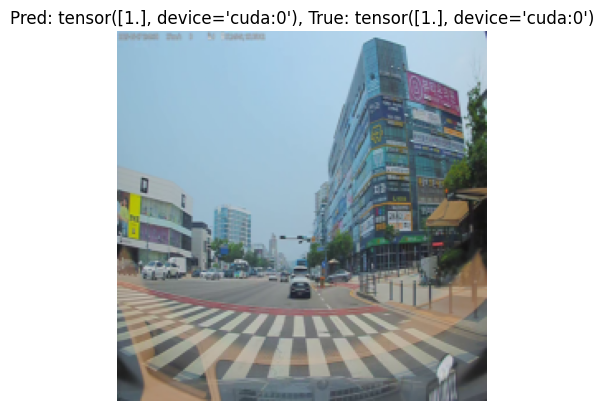

 12%|█▎        | 3/24 [00:00<00:03,  6.60it/s]

tensor([[13.5042]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


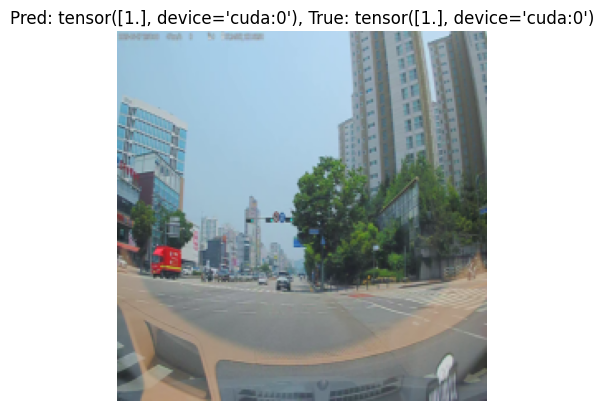

 17%|█▋        | 4/24 [00:00<00:02,  6.70it/s]

tensor([[10.2864]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


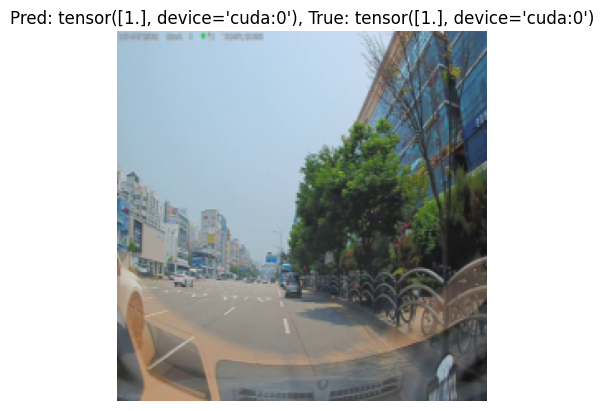

 21%|██        | 5/24 [00:00<00:02,  6.81it/s]

tensor([[6.5052]], device='cuda:0')
tensor([[0.9985]], device='cuda:0')


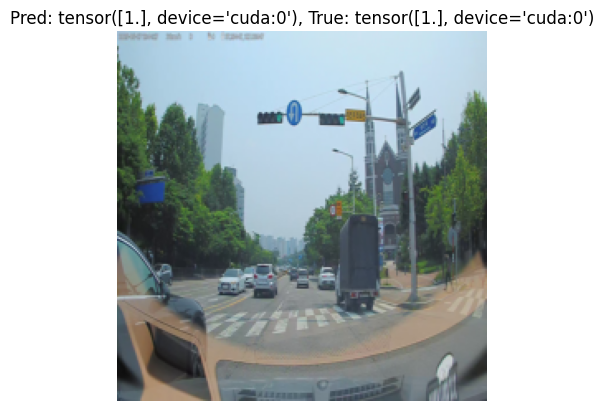

 25%|██▌       | 6/24 [00:00<00:02,  6.83it/s]

tensor([[7.7651]], device='cuda:0')
tensor([[0.9996]], device='cuda:0')


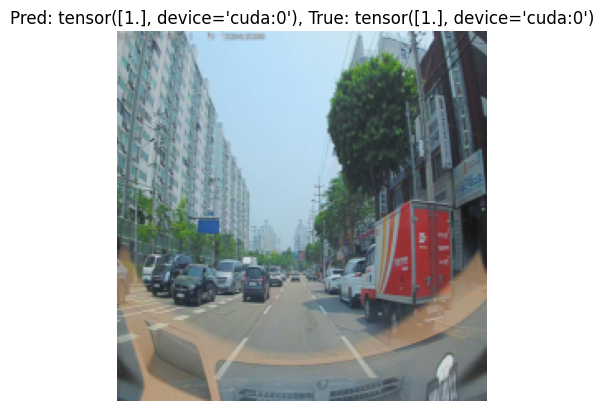

 29%|██▉       | 7/24 [00:01<00:02,  6.73it/s]

tensor([[8.1546]], device='cuda:0')
tensor([[0.9997]], device='cuda:0')


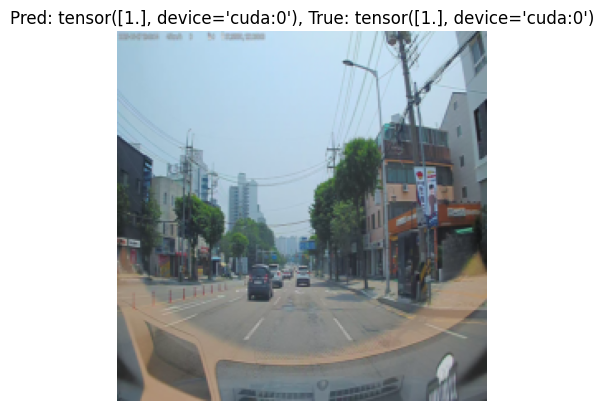

 33%|███▎      | 8/24 [00:01<00:02,  6.77it/s]

tensor([[9.4801]], device='cuda:0')
tensor([[0.9999]], device='cuda:0')


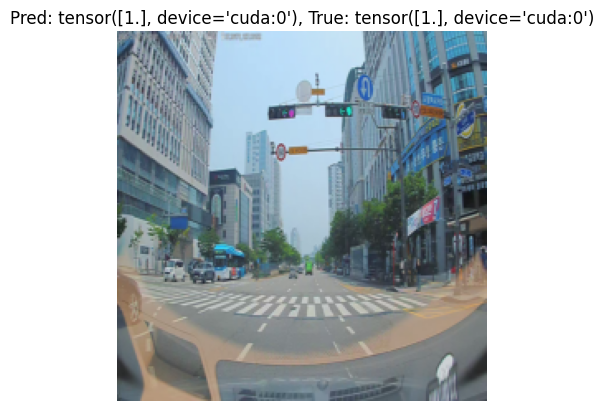

 38%|███▊      | 9/24 [00:01<00:02,  6.69it/s]

tensor([[11.4708]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


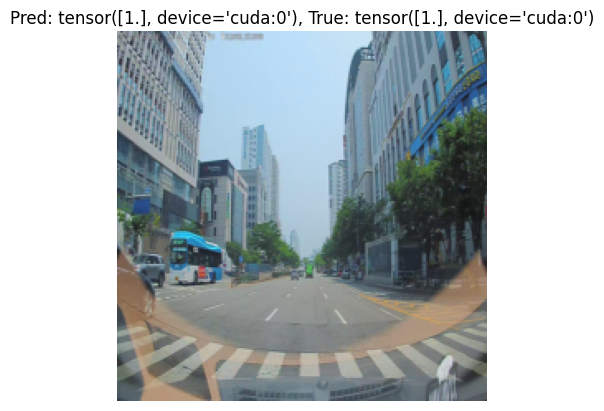

 42%|████▏     | 10/24 [00:01<00:02,  6.63it/s]

tensor([[16.3288]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


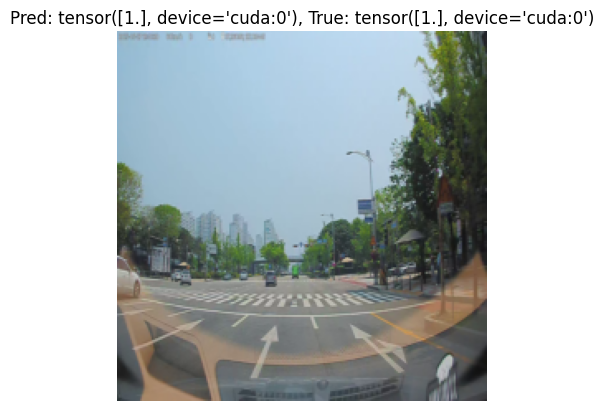

 46%|████▌     | 11/24 [00:01<00:01,  6.73it/s]

tensor([[6.3515]], device='cuda:0')
tensor([[0.9983]], device='cuda:0')


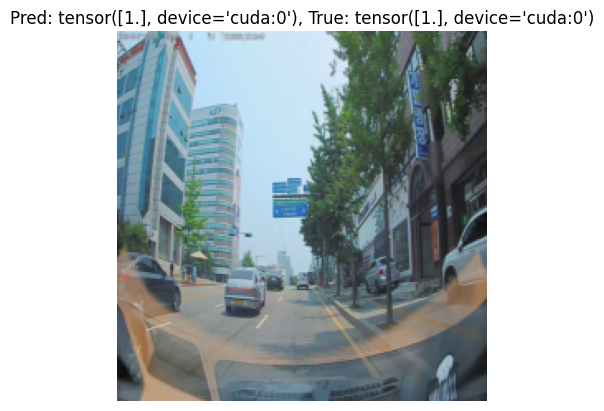

 50%|█████     | 12/24 [00:01<00:01,  6.65it/s]

tensor([[7.4109]], device='cuda:0')
tensor([[0.9994]], device='cuda:0')


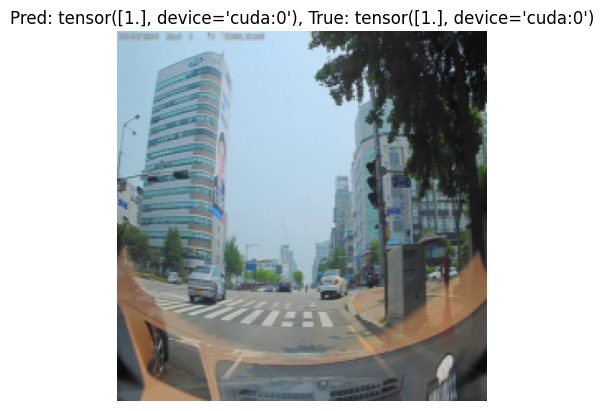

 54%|█████▍    | 13/24 [00:01<00:01,  6.63it/s]

tensor([[19.6508]], device='cuda:0')
tensor([[1.]], device='cuda:0')


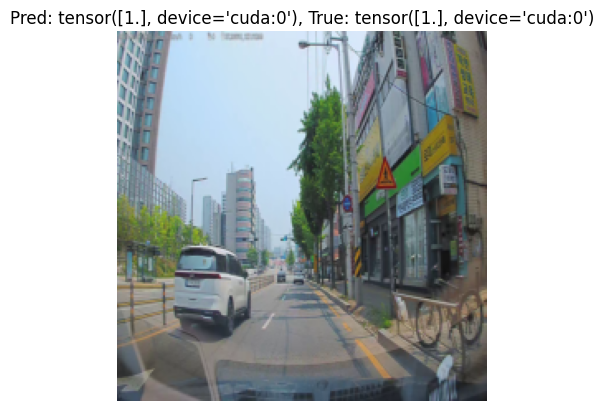

 58%|█████▊    | 14/24 [00:02<00:01,  6.67it/s]

tensor([[19.6835]], device='cuda:0')
tensor([[1.]], device='cuda:0')


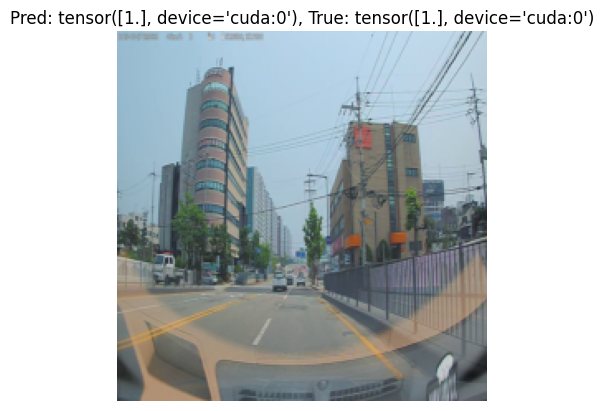

 62%|██████▎   | 15/24 [00:02<00:01,  6.69it/s]

tensor([[8.7515]], device='cuda:0')
tensor([[0.9998]], device='cuda:0')


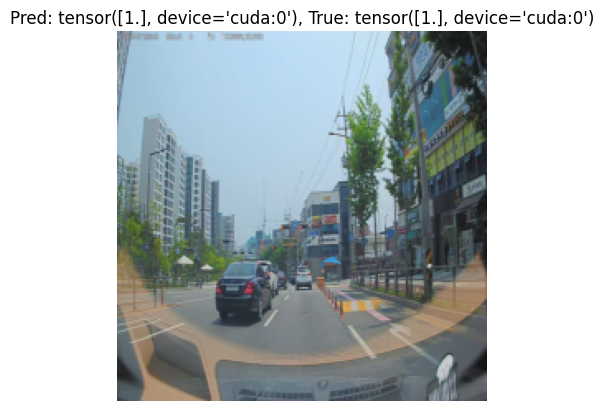

 67%|██████▋   | 16/24 [00:02<00:01,  6.74it/s]

tensor([[7.5860]], device='cuda:0')
tensor([[0.9995]], device='cuda:0')


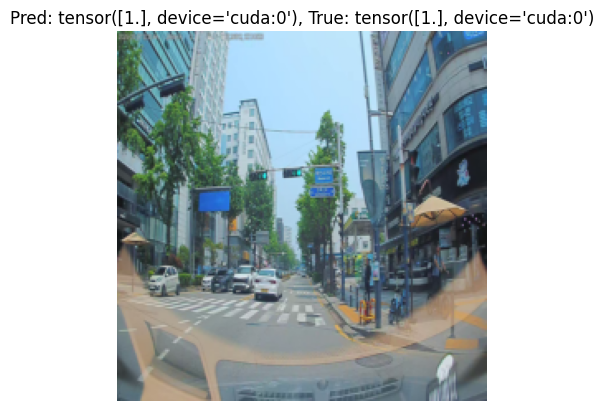

 71%|███████   | 17/24 [00:02<00:01,  6.71it/s]

tensor([[14.1846]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


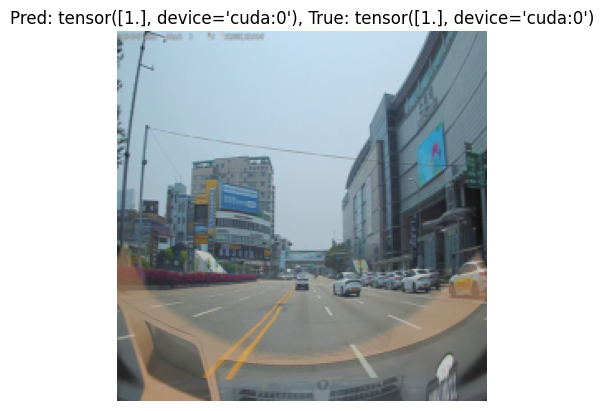

 75%|███████▌  | 18/24 [00:02<00:00,  6.74it/s]

tensor([[17.8789]], device='cuda:0')
tensor([[1.]], device='cuda:0')


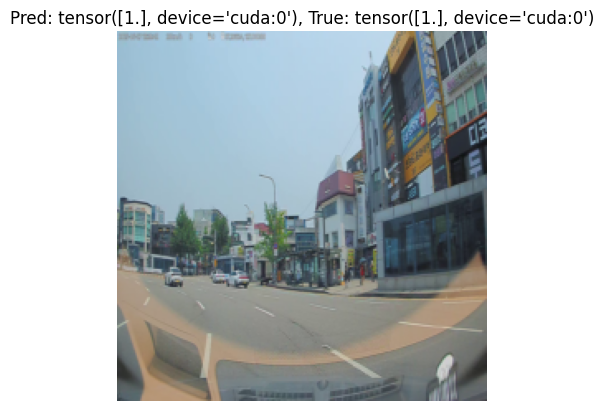

 79%|███████▉  | 19/24 [00:02<00:00,  6.72it/s]

tensor([[9.3175]], device='cuda:0')
tensor([[0.9999]], device='cuda:0')


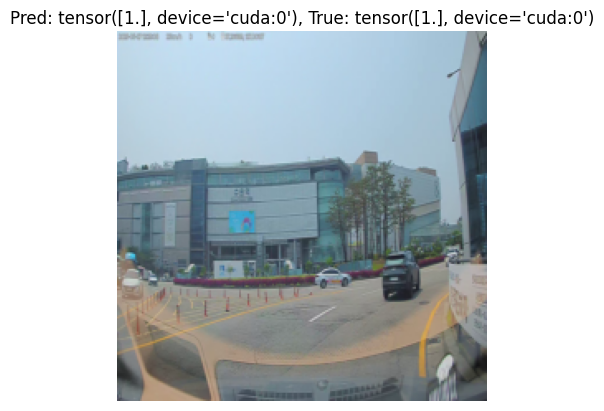

 83%|████████▎ | 20/24 [00:02<00:00,  6.67it/s]

tensor([[12.9276]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


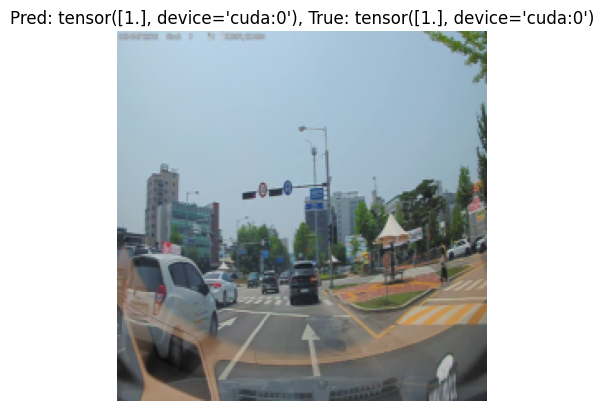

 88%|████████▊ | 21/24 [00:03<00:00,  6.61it/s]

tensor([[11.4722]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


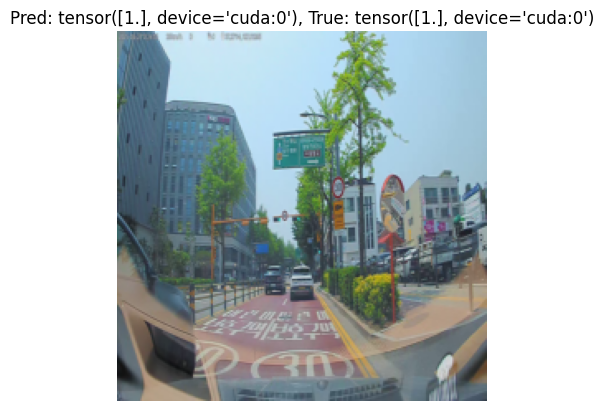

 92%|█████████▏| 22/24 [00:03<00:00,  6.47it/s]

tensor([[6.8450]], device='cuda:0')
tensor([[0.9989]], device='cuda:0')


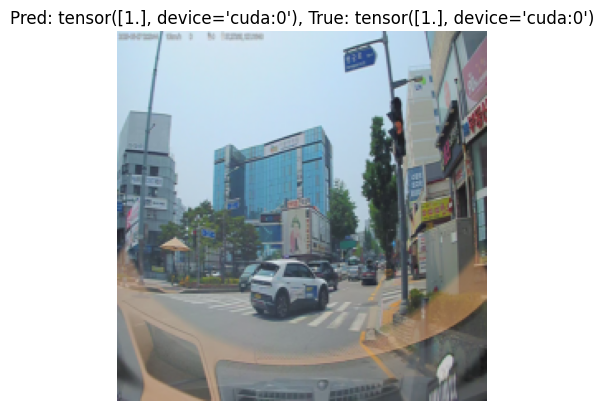

 96%|█████████▌| 23/24 [00:03<00:00,  6.43it/s]

tensor([[16.2102]], device='cuda:0')
tensor([[1.0000]], device='cuda:0')


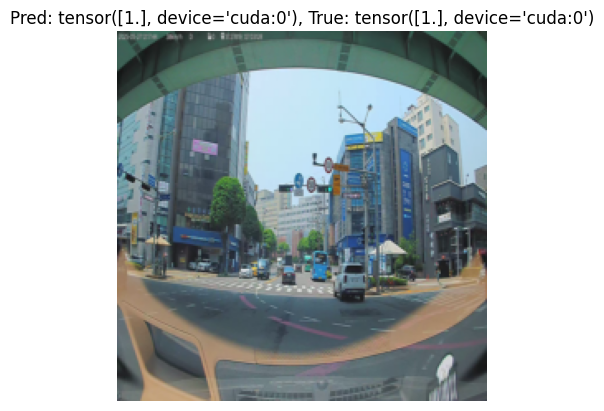

100%|██████████| 24/24 [00:03<00:00,  6.62it/s]


In [22]:
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        print(outputs)
        outputs = torch.sigmoid(outputs)
        print(outputs)
        preds = (outputs > 0.1).float()


        labels = labels.unsqueeze(1).float()

        for i in range(len(images)):
            img = images[i].cpu().permute(1, 2, 0)
            mean = torch.tensor([0.4914, 0.4822, 0.4465])
            std = torch.tensor([0.2470, 0.2435, 0.2616])
            img = img * std + mean
            img = img.clamp(0, 1)

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Pred: {preds[i]}, True: {labels[i]}")
            plt.show()

